In [67]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.datasets import Cityscapes

import numpy as np

from PIL import Image

import os

from matplotlib import pyplot as plt

from torchvision import transforms as T

In [5]:
IGNORE_INDEX = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [IGNORE_INDEX, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)
class_map

colors = [
    [0, 0, 0],
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [0, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [6]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = IGNORE_INDEX
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [55]:
transform = A.Compose([ A.Resize(256, 512) ])

class CityscapesDataset(Cityscapes):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        smnt = Image.open(self.targets[index][0])

        if self.transforms is not None:
            transformed = self.transforms(image=np.array(img), mask=np.array(smnt))
            img = transformed['image']
            smnt = transformed['mask']
        smnt = encode_segmap(smnt)
        return img, smnt

In [56]:
datasets = {}
input_path = './data/cityscapes'
output_path = './data/cityscapes_preprocessed'

for key in ['train', 'val', 'test']:
    datasets[key] = CityscapesDataset(input_path, split=key, mode='fine', target_type='semantic', transforms=transform)

In [94]:
os.makedirs(output_path, exist_ok=True)
for key, dataset in datasets.items():
    os.makedirs(os.path.join(output_path, key), exist_ok=True)
    for i, (x, y) in enumerate(dataset):
        np.save(os.path.join(output_path, key, f'{i}.npy'), x)
        np.save(os.path.join(output_path, key, f'y{i}.npy'), y)
        if i%100==0:
            print('.', end='')
    print()
    print(key, 'done')

..............................
train done
.....
val done
................
test done


In [95]:
class CityscapesPreprocessedDataset(Dataset):
    def __init__(self, root, split, transforms=None):
        self.root = root
        self.split = split
        self.transforms = transforms

    def __getitem__(self, index):
        x = np.load(os.path.join(self.root, self.split, f'{index}.npy'))
        y = np.load(os.path.join(self.root, self.split, f'y{index}.npy'))

        if self.transforms is not None:
            transformed = self.transforms(image=x, mask=y)
            x = transformed['image']
            y = transformed['mask']
        return x, y

In [96]:
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [97]:
def decode_segmap(temp):
    #convert gray scale to color
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [106]:
more_transforms = A.Compose([
    A.HorizontalFlip(),
    A.ColorJitter(hue=0),
    A.Normalize(),
    ToTensorV2()
    ])

preprocessed = CityscapesPreprocessedDataset(output_path, 'val', more_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054901965..1.0222223].


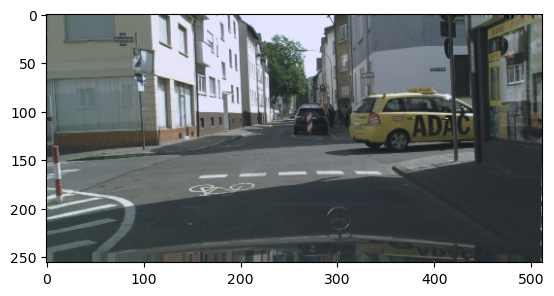

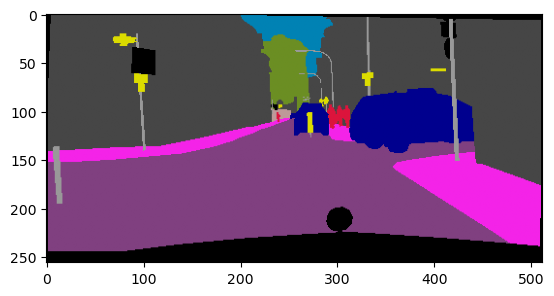

In [108]:
for x, y in preprocessed:
    img = inv_normalize(x)
    plt.imshow(np.moveaxis(img.numpy(), 0, 2))
    plt.show()
    y = decode_segmap(y)
    plt.imshow(y)
    plt.show()
    break